In [1]:
from lime import lime_text## for word embedding
import gensim
import gensim.downloader as gensim_api## for deep learning
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,confusion_matrix
from tensorflow.keras import models, layers, preprocessing as kprocessing
from gensim.models import Word2Vec
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model

In [13]:
df = pd.read_csv(r'/content/data/Reviews.csv')

In [14]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [15]:
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True)

,Text,Score
0,not like her mc books did not enjoy this story...,0
1,if you like loveatfirstsight romances this wil...,0
2,only very poor desperate writers resort to cli...,0
3,im sorry i had to stop reading evie was one of...,0
4,very superficial the entire book read like a p...,0
...,...,...
59989,i want more already added it to my wish list t...,1
59990,i received this book from the author as a pape...,1
59991,funny and brilliant i have to admit i was nt s...,1
59992,lovely story,1


In [16]:
df['Score'].value_counts()

0    29998
1    29996
Name: Score, dtype: int64

In [17]:
from sklearn import model_selection
#split data into training data and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(df['Text'],df['Score'],random_state=3, shuffle = True,stratify=df['Score'])

In [18]:
x_train.head()

37140    loving the entire series this one is just as g...
23964    you only get so many views before they begin a...
16928    the story is good however the book is hard to ...
5927     i was not happy with one she was interested bu...
12887    i gave this novel two stars because it had a g...
Name: Text, dtype: object

In [19]:
y_train.head()

37140    1
23964    0
16928    0
5927     0
12887    0
Name: Score, dtype: int64

In [20]:
## fit word2vec nlp word embedding
corpus = x_train
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus],
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=100,   
            window=5, min_count=5, sg=1, iter=30)

In [21]:
nlp.save('model\word2vec_100.model')

#nlp=Word2Vec.load('model\word2vec_100.model')

In [22]:
word = "data"
nlp[word].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(100,)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

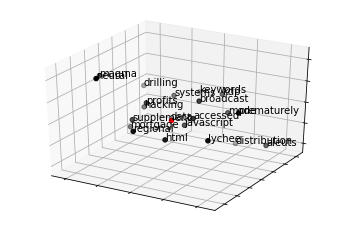

In [23]:
import matplotlib
import matplotlib.pyplot as plt
word = "data"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 100 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [24]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=90, padding="post", truncating="post")

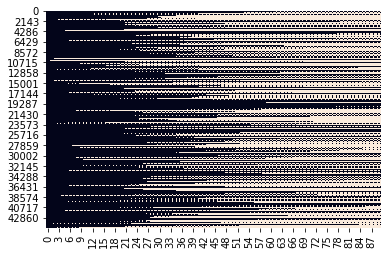

In [25]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [26]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(x_train.iloc[i].split())
print("from: ", x_train.iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", x_train.iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[x_train.iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  loving the entire series this one is just as good as the others easy fun read with new characters and previous ones | len: 22
to:  [637   2 446  56   9  34  10  32  28  59  28   2 298 324 250  26  19 146
  55   3 502 634   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0] | len: 90
check:  loving  -- idx in vocabulary --> 637
vocabulary:  {'NaN': 1, 'the': 2, 'and': 3, 'i': 4, 'to': 5} ... (padding element, 0)


In [27]:
#test vec
corpus = x_test
## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    ## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=90,
             padding="post", truncating="post")

In [28]:
a = 0
b=0
for i in range(len(lst_text2seq)):
    a+=len(lst_text2seq[i])
    b+=1
a/b

89.77631842122808

In [29]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 100))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [30]:
embeddings.shape

(60749, 100)

In [31]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 6841 |idx
embeddings[idx]: (100,) |vector


In [32]:
print(X_train)

[[637   2 446 ...   0   0   0]
 [ 24  94  68 ...   0   0   0]
 [  2  23  10 ...   0   0   0]
 ...
 [ 40  51   5 ...   0   0   0]
 [  2 551 161 ...   0   0   0]
 [  4  53 135 ...   0   0   0]]


# CNN 3 layers

In [33]:
from keras.utils import to_categorical
y_train_cnn = to_categorical(y_train, 2)
y_test_cnn = to_categorical(y_test, 2)

In [34]:
embeddings.shape

(60749, 100)

In [35]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import regularizers
sequence_length = 90
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.25
EMBEDDING_DIM = 100

inputs = Input(shape=(sequence_length,))
embedding = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=sequence_length, trainable=False)(inputs)

reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)#卷积层
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)#池化层
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model_cnn = Model(inputs, output)

model_cnn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 100)      6074900     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 90, 100, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 88, 1, 100)   30100       reshape[0][0]                    
_______________________________________________________________________________________

In [36]:
X_train.shape

(44995, 90)

In [37]:
y_test.shape

(14999,)

In [38]:
adam = Adam(lr=1e-4)

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss')]
model_cnn.fit(X_train, y_train_cnn, batch_size=100, epochs=10, verbose=1, #validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training



Epoch 1/10
450/450 [==============================] - 62s 137ms/step - loss: 0.5312 - acc: 0.8494
Epoch 2/10
450/450 [==============================] - 62s 138ms/step - loss: 0.4235 - acc: 0.8767
Epoch 3/10
450/450 [==============================] - 62s 138ms/step - loss: 0.4065 - acc: 0.8842
Epoch 4/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3990 - acc: 0.8873
Epoch 5/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3941 - acc: 0.8903
Epoch 6/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3912 - acc: 0.8921
Epoch 7/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3889 - acc: 0.8941
Epoch 8/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3875 - acc: 0.8952
Epoch 9/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3861 - acc: 0.8951
Epoch 10/10
450/450 [==============================] - 62s 138ms/step - loss: 0.3854 - acc: 0.8964


In [39]:
#sequences_test=tokenizer.texts_to_sequences(X_test.tolist())
#X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])
y_pred=model_cnn.predict(X_test)


In [40]:
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}

In [41]:
y_test_cnn.shape

(14999, 2)

In [42]:
y_pred.shape

(14999, 2)

In [43]:
from sklearn.metrics import classification_report
predicted = [dic_y_mapping[np.argmax(pred)] for pred in y_pred]
y_test_c = [dic_y_mapping[np.argmax(t)] for t in y_test_cnn]
accuracy = accuracy_score(y_test_c, predicted)
print('Accuracy: ',accuracy)
print(classification_report(y_test_c, predicted))

Accuracy:  0.8728581905460364
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7500
           1       0.87      0.87      0.87      7499

    accuracy                           0.87     14999
   macro avg       0.87      0.87      0.87     14999
weighted avg       0.87      0.87      0.87     14999



# BiLSTM 2 layers

In [45]:
## attention layer
dic_yt_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_test))}

def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x
## input
input_shape = 90
x_in = layers.Input(shape=(input_shape,))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=input_shape, trainable=False)(x_in)

## apply attention
x = attention_layer(x, neurons=input_shape)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=input_shape, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=input_shape, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 90, 100)      6074900     input_2[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 100, 90)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100, 90)      8190        permute[0][0]                    
_______________________________________________________________________________________

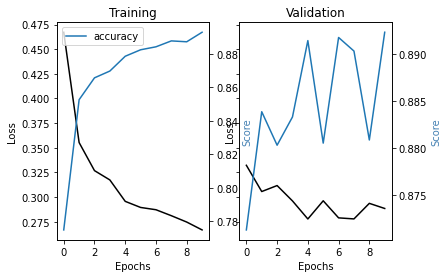

In [46]:
## encode y
## train
training = model.fit(x=X_train, y=y_train, batch_size=100, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.2)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [47]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

In [48]:
predicted = np.array(predicted)

In [49]:
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
inverset_dic = {v:k for k,v in dic_yt_mapping.items()}
y_test1 = np.array([inverset_dic[y] for y in y_test])

In [50]:
## Accuracy
from sklearn.metrics import classification_report
accuracy = accuracy_score(y_test, predicted)
print(accuracy)
print(classification_report(y_test, predicted))

0.8716581105407027
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7500
           1       0.87      0.88      0.87      7499

    accuracy                           0.87     14999
   macro avg       0.87      0.87      0.87     14999
weighted avg       0.87      0.87      0.87     14999

